In [561]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns

sns.set(context="paper",font_scale=1.6,style="darkgrid")


import scipy as sp
import scipy.constants as const

import sympy as sym
sym.init_printing()

import pandas as pd

import ROOT as rt

import root_numpy as rnp

import re

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [73]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])
    
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)


#Vorbereitungsaufgaben

##Aufgabe 5

In [89]:
#W2 = sym.sqrt(2)
#A_np = np.matrix([[1,1,1,0,0,0,0,0,0],[0,0,0,1,1,1,0,0,0],[0,0,0,0,0,0,1,1,1],
#               [0,0,W2,0,0,0,0,0,0],[0,W2,0,0,0,W2,0,0,0],[W2,0,0,0,W2,0,0,0,W2],
#               [0,0,0,W2,0,0,0,W2,0],[0,0,0,0,0,0,W2,0,0],[0,0,W2,0,0,W2,0,0,W2],
#               [0,W2,0,0,W2,0,0,W2,0],[W2,0,0,W2,0,0,W2,0,0]])
#A = sym.Matrix(A_np)
#B = (A.transpose()*A)
#B.inv()
# B ist singulär

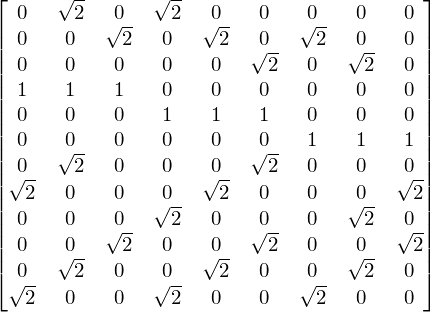

In [399]:
W2 = sym.sqrt(2)
A_np = np.matrix([[0,W2,0,W2,0,0,0,0,0],[0,0,W2,0,W2,0,W2,0,0],[0,0,0,0,0,W2,0,W2,0],
                [1,1,1,0,0,0,0,0,0],[0,0,0,1,1,1,0,0,0],[0,0,0,0,0,0,1,1,1],
               [0,W2,0,0,0,W2,0,0,0],[W2,0,0,0,W2,0,0,0,W2],[0,0,0,W2,0,0,0,W2,0],
               [0,0,W2,0,0,W2,0,0,W2],[0,W2,0,0,W2,0,0,W2,0],[W2,0,0,W2,0,0,W2,0,0]])
#B_np = (A_np.T * A).inv()


A = sym.Matrix(A_np)
C = (A.transpose()*A).inv()
A


##Suche nach Integrationsintervall

In [ ]:
values = [4503,2978,6396,5013,4969,5458,6046,3073,4990,4920,4918,5422]
values = [2994,1296,5373,3239,2978,3603,3220,1323,4363,3224,3099,4188]

filepath = "/home/josh/Dokumente/Studium/FP_Physik/FP_Repo/01_TomographieGamma[ ]/Messdaten/20151102_Joshua_Leonard/Block2/Messung_{}.dat"
global_limits = set([])
for k,n in enumerate(values,start=1):
    global global_limits
    print("Messung {}".format(k))
    File = filepath.format(k)
    x,y = np.loadtxt(File,unpack=True)
    print(y[250:310].sum(),"\t",n)
    limits = set([])
    for i in range(200,300):
        for j in range(250,350):
            if sum(y[i:j]) == n:
                limits.add((i,j))
    if k == 1:
        global_limits = limits
    else:
        global_limits = global_limits.intersection(limits)
                #print(i,j)

print(global_limits)

#Auswertung

##Laden der Daten

In [377]:
# Speicherort der Messdaten 
folder = "/home/josh/Dokumente/Studium/FP_Physik/FP_Repo/01_TomographieGamma[ ]/Messdaten/20151102_Joshua_Leonard/"

# Ordner der Messreihen
cube = ["Luft/","Block1/","Block2/","Block3/"]

# Intergrationsgrenzen
lower_limit, upper_limit = 250, 310

# Kanalnummern
channels = np.arange(0,1024)

# Laden der Daten einer Messreihe
def load_data(num_cube=0):
    data = []
    real_times = []
    live_times = []
    for i in range(1,13):
        File = "Messung_{}.dat".format(i) 
        with open(folder+cube[num_cube]+File) as dat:
            line = dat.readline()
            while line:
                if "Real Time" in line: 
                    m = re.search("\d{3}.\d{3}",line)
                    real_times.append(float(m.group(0)))
                if "Live Time" in line:
                    m = re.search("\d{3}.\d{3}",line)
                    live_times.append(float(m.group(0)))
                    break
                line = dat.readline()
        data.append(np.loadtxt(folder+cube[num_cube]+File,unpack=True)[1])
    data,real_times, live_times = np.array(data),np.array(real_times),np.array(live_times)
    return data,real_times,live_times

In [464]:
# Laden der Messdaten und jeweilige Livetime für alle Projektionen und jeden Würfel
cube_0,real_time_0,live_time_0 = load_data(num_cube=0)
cube_1,real_time_1,live_time_1 = load_data(num_cube=1)
cube_2,real_time_2,live_time_2 = load_data(num_cube=2)
cube_3,real_time_3,live_time_3 = load_data(num_cube=3)

# Wurde 12 mal gemessen verlangt ist jedoch nur ein Wert, daher Mittelung
#cube_0 = cube_0.mean(axis=0)
real_time_0 = real_time_0.mean()
live_time_0 = live_time_0.mean()



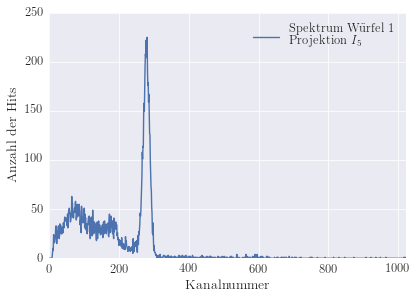

In [572]:
# Plot eines Spektrums aus der 5.Messung von Cube 1
plt.xlim(0,1023)
plt.xlabel("Kanalnummer")
plt.ylabel("Anzahl der Hits")
plt.plot(channels,cube_1[4],label=u"Spektrum Würfel 1\n Projektion $I_{5}$ ")
plt.legend(loc="upper right")
plt.savefig(path_graphics+"Spektrum_Block_1_Messung_5_0_1023.pdf")

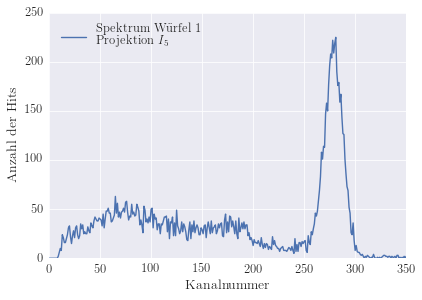

In [574]:
# Plot eines Spektrums aus der 5.Messung von Cube 1
plt.xlim(0,350)
plt.xlabel("Kanalnummer")
plt.ylabel("Anzahl der Hits")
plt.plot(channels,cube_1[4],label=u"Spektrum Würfel 1\n Projektion $I_{5}$ ")
plt.legend(loc="upper left")
plt.savefig(path_graphics+"Spektrum_Block_1_Messung_5_0_350.pdf")

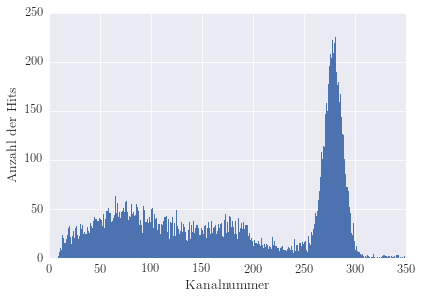

In [587]:
# Plot eines Spektrums aus der 5.Messung von Cube 1
plt.xlim(0,350)
plt.xlabel("Kanalnummer")
plt.ylabel("Anzahl der Hits")
plt.bar(channels,cube_1[4],width=1,align="center",edgecolor="")#,label=u"Spektrum Würfel 1\n Projektion $I_{5}$ ")
plt.legend(loc="upper left")
plt.savefig(path_graphics+"Spektrum_Block_1_Messung_5_0_350_bar.pdf")

In [444]:
live_time_0
cube_0

array([ 0.        ,  0.5       ,  0.16666667, ...,  0.08333333,
        0.        ,  0.        ])

In [451]:
# Integrierte Hits im Intervall [250,310] 
# Cube 0 wurde 12 mal gemessen verlangt ist jedoch nur ein Wert, daher Mittelung
integrated_counts_0 = cube_0[:,lower_limit:upper_limit].sum(axis=1).mean()
integrated_counts_1 = cube_1[:,lower_limit:upper_limit].sum(axis=1)
integrated_counts_2 = cube_2[:,lower_limit:upper_limit].sum(axis=1)
integrated_counts_3 = cube_3[:,lower_limit:upper_limit].sum(axis=1)



In [459]:
integrated_counts_0

In [452]:
# Fehlerbehaftete Integrierte Hits im Intervall [250,310]
integrated_counts_0_err = unp.uarray(integrated_counts_0,np.sqrt(integrated_counts_0)) 
integrated_counts_1_err = unp.uarray(integrated_counts_1,np.sqrt(integrated_counts_1)) 
integrated_counts_2_err = unp.uarray(integrated_counts_2,np.sqrt(integrated_counts_2))
integrated_counts_3_err = unp.uarray(integrated_counts_3,np.sqrt(integrated_counts_3)) 


In [453]:
integrated_counts_0_err

array(29374.75+/-171.39063568351685, dtype=object)

In [467]:
# Renormierung der integrierten Hits
integrated_counts_0_norm_1 = integrated_counts_0*(real_time_1/live_time_0)
integrated_counts_1_norm = integrated_counts_1*(real_time_1/live_time_1)

integrated_counts_0_norm_2 = integrated_counts_0*(real_time_2/live_time_0)
integrated_counts_2_norm = integrated_counts_2*(real_time_2/live_time_2)

integrated_counts_0_norm_3 = integrated_counts_0*(real_time_3/live_time_0)
integrated_counts_3_norm = integrated_counts_3*(real_time_3/live_time_3)



In [470]:
integrated_counts_0_norm_3

array([ 44194.09347357,  44194.09347357,  44194.09347357,  44194.09347357,
        44194.09347357,  44194.09347357,  44194.09347357,  44194.09347357,
        44194.09347357,  44194.09347357,  44194.09347357,  44194.09347357])

In [471]:
# Renormierung der fehlerbehafteten integrierten Hits
integrated_counts_0_norm_1_err = integrated_counts_0_err*(real_time_1/live_time_0)
integrated_counts_1_norm_err = integrated_counts_1_err*(real_time_1/live_time_1)

integrated_counts_0_norm_2_err = integrated_counts_0_err*(real_time_2/live_time_0)
integrated_counts_2_norm_err = integrated_counts_2_err*(real_time_2/live_time_2)

integrated_counts_0_norm_3_err = integrated_counts_0_err*(real_time_3/live_time_0)
integrated_counts_3_norm_err = integrated_counts_3_err*(real_time_3/live_time_3)


In [472]:
integrated_counts_0_norm_1_err

array([29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236,
       29462.728982377932+/-171.90396000854236], dtype=object)

In [473]:
# Logarithmierte Verhältnisse
log_ratios_1 = np.log(integrated_counts_0_norm_1/integrated_counts_1_norm)
log_ratios_2 = np.log(integrated_counts_0_norm_2/integrated_counts_2_norm)
log_ratios_3 = np.log(integrated_counts_0_norm_3/integrated_counts_3_norm)

In [476]:
# Fehlerbehaftete Logarithmierte Verhältnisse
log_ratios_1_err = unp.log(integrated_counts_0_norm_1_err/integrated_counts_1_norm_err)
log_ratios_2_err = unp.log(integrated_counts_0_norm_2_err/integrated_counts_2_norm_err)
log_ratios_3_err = unp.log(integrated_counts_0_norm_3_err/integrated_counts_3_norm_err)

In [487]:
log_ratios_1_err

array([1.8767141418060758+/-0.016003656322588235,
       2.2892038774085113+/-0.019231190266061123,
       1.5252842279696597+/-0.013798208588115314,
       1.7694234448441442+/-0.015281498336607177,
       1.7770700727858637+/-0.015339184426845596,
       1.6840416152693878+/-0.014739746898455459,
       1.5817271411982683+/-0.014122374218575378,
       2.258970630951593+/-0.018959370952655978,
       1.77352111317794+/-0.015311552648932065,
       1.7874814499244427+/-0.015404378450237363,
       1.7875538678763276+/-0.01540706110248603,
       1.6899910605938546+/-0.014780955016094973], dtype=object)

In [479]:
# Berechnung der Absorbtionskoeffizienten
def attenuation_coefficients(log_ratios):
    attenuation_coeff = []
    coeffs = C*A.transpose()*log_ratios
    for coeff in coeffs:
        attenuation_coeff.append(float(coeff))
    return np.array(attenuation_coeff)    




In [485]:
attenuation_coeff_1 = attenuation_coefficients(log_ratios_1)
attenuation_coeff_2 = attenuation_coefficients(log_ratios_2)

In [486]:
attenuation_coeff_1

array([ 0.4046063 ,  0.56008072,  0.54579275,  0.65598641,  0.53515335,
        0.46392776,  0.40082437,  0.50364089,  0.52063269])

In [387]:
integrated_counts_0_norm_2

array([ 80679.84288818,  80398.19458375,  80114.491058  ,  82682.10702341,
        81725.18382353,  79137.66298897,  80042.37713139,  80941.31416151,
        80884.19117647,  81482.19658977,  82511.03863522,  81672.65585827])

In [302]:
a = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [310]:
a[:,2:4]

array([[ 3,  4],
       [ 7,  8],
       [11, 12]])